# Housing Prices Prediction using Regression
---

This code aims to predict housing prices in the city of Ames, Iowa using regression. The data is taken from the Kaggle competition for Housing prices prediction. We will analyze the data and clean it, and then run regression algorithms to achieve the lowest prediction error. The error metric used in this code is RMSE.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
 #       print(os.path.join(dirname, filename))

In [60]:
!pip install xgboost

In [3]:
# Read the data
X = pd.read_csv('train.csv', index_col='Id')
X_test_full = pd.read_csv('test.csv', index_col='Id')

## Exploratory Data Analysis:

We shall look at the data and see what can be changed and what needs to be removed, so that a regression algorithm can better predict the final outcome, i.e. the price.
The dataset has 81 features and 1460 houses. Our target feature is the "SalePrice". The features are a mix of numerical and categorical features.

In [4]:
print("Shape of training set:",format(X.shape))
print("Shape of test set:",format(X_test_full.shape))

Shape of training set: (1460, 80)
Shape of test set: (1459, 79)


In [5]:
X.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


We take a look at the correlation between numerical features and the target "SalePrice", in order to have a first idea of the connections between features. Darker colors indicate a strong correlation and vice versa. As we can see, there are quite a few features in the dataset having a strong correlation with the Sale Price. This means that, changes in these features lead to changes in the target variable.

(array([0.5]), <a list of 1 Text yticklabel objects>)

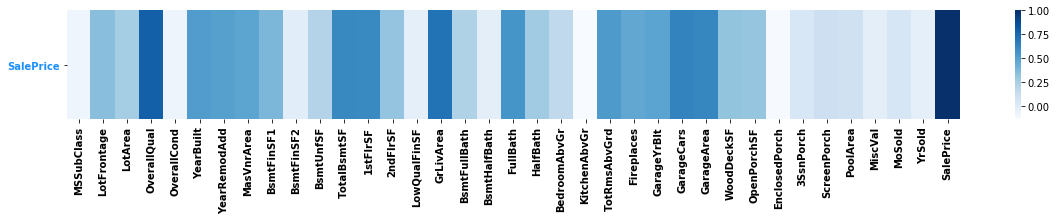

In [6]:
num_X = X.select_dtypes(exclude='object')
num_X_cor = num_X.corr()
f,ax=plt.subplots(figsize=(20,2))
sns.heatmap(num_X_cor.sort_values(by=['SalePrice'], ascending=False).head(1), cmap='Blues')
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)

We see the top 10 features with high correlation to Sale Price.

In [7]:
high_cor_num = num_X_cor['SalePrice'].sort_values(ascending=False).head(10).to_frame()
high_cor_num

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


The overall quality, the living area, basement area, garage cars(no. of cars that can be accomodated in the garage) and garage area have the highest correlation values with the sale price. That makes sense, as greater the area, higher the price. Also, better quality of the house yields a higher price.


We shall now look at the categorical features, as some categorical features like neighborhood tend to have a big impact on the price of a house. Houses in posh neighborhoods will be costlier than others.
Below, we check the number of houses for each neighborhood in our dataset.

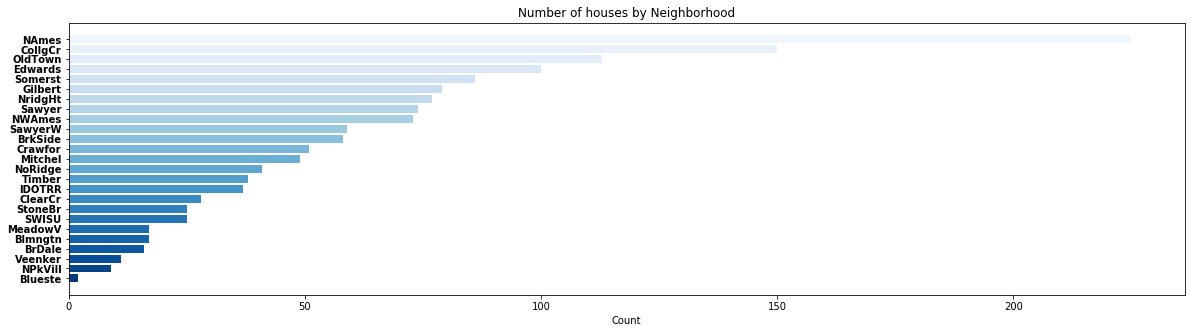

In [8]:
f,ax=plt.subplots(figsize=(20,5))

nbr_count = X.Neighborhood.value_counts().to_frame().reset_index() #getting the number of houses for each neighborhood

nbr_plt = ax.barh(nbr_count.iloc[:,0], nbr_count.iloc[:,1], color=sns.color_palette('Blues',len(nbr_count)))

ax.invert_yaxis()
plt.yticks(weight='bold')
plt.xlabel('Count')
plt.title('Number of houses by Neighborhood')
plt.show()

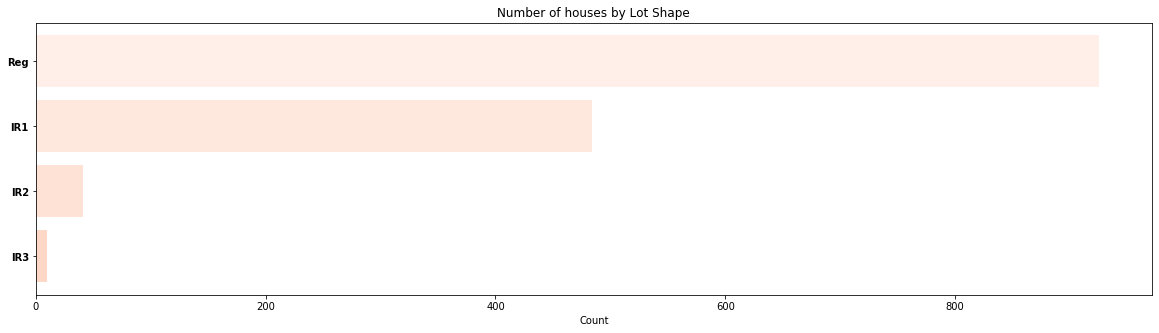

In [9]:
f,ax=plt.subplots(figsize=(20,5))

lotshape_count = X.LotShape.value_counts().to_frame().reset_index() #getting the number of houses for each neighborhood

nbr_plt = ax.barh(lotshape_count.iloc[:,0], lotshape_count.iloc[:,1], color=sns.color_palette('Reds',len(nbr_count)))

ax.invert_yaxis()
plt.yticks(weight='bold')
plt.xlabel('Count')
plt.title('Number of houses by Lot Shape')
plt.show()

In [10]:
X.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

As it turns out, almost all the houses have all utilities. Hence, this column can be dropped.

### Combining the training and testing sets before cleaning the data:

In [11]:
nX = X.shape[0]
nX_test = X_test_full.shape[0]
y_train = X['SalePrice'].to_frame()
#Combine train and test sets
combined_df = pd.concat((X,X_test_full), sort=False).reset_index(drop=True)

#Drop the target "SalePrice" and Id columns
combined_df.drop(['SalePrice'], axis=1, inplace=True)
print(f"Total size is {combined_df.shape}")


Total size is (2919, 79)


## Data Cleaning

First, we take a look at the columns with the highest percentage of null values.

In [12]:
nullpercentage = (combined_df.isnull().mean())*100
nullpercentage = nullpercentage.sort_values(ascending=False).to_frame()
nullpercentage.head()

,0
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797


We will get rid of the features with more than 80% missing values . For example the PoolQC's missing values are probably due to the lack of pools in some buildings, which is very logical. But replacing those (more than 80%) missing values with "no pool" will leave us with a feature with low variance, and low variance features are uniformative for machine learning models. So we drop the features with more than 80% missing values.
The threshold for percentage of missing values can be changed as required depending on the dataset, and number of columns that would get dropped.

### Function to visualize columns with null values

In [13]:
def msv1(data, thresh=20, color='black', edgecolor='black', width=15, height=3):
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    
    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh} missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

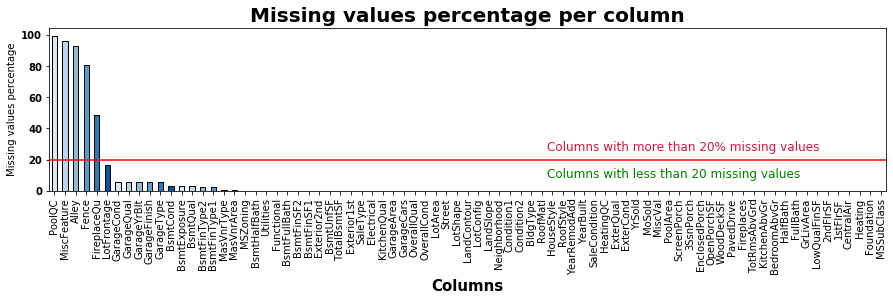

In [14]:
msv1(combined_df, color=sns.color_palette('Blues'))

Most of the features do not have any null values and some have very few. We drop those columns from the dataset which have more than 20% missing values.

In [15]:
combined_df1 = combined_df.dropna(thresh=len(combined_df)*0.8, axis=1) #dropping columns with more than 20% null values
print(f"We dropped {combined_df.shape[1]-combined_df1.shape[1]} features in the combined set")

We dropped 5 features in the combined set


In [16]:
combined_df1.select_dtypes(exclude='object').isnull().sum().sort_values(ascending=False).head(11)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
dtype: int64

In [17]:
def msv2(data, width=12, height=8, color=('silver', 'gold','lightgreen','skyblue','lightpink'), edgecolor='black'):
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    fig, ax = plt.subplots(figsize=(width, height))

    allna = (data.isnull().sum() / len(data))*100
    tightout= 0.008*max(allna)
    allna = allna.drop(allna[allna == 0].index).sort_values().reset_index()
    mn= ax.barh(allna.iloc[:,0], allna.iloc[:,1], color=color, edgecolor=edgecolor)
    ax.set_title('Missing values percentage per column', fontsize=15, weight='bold' )
    ax.set_xlabel('Percentage', weight='bold', size=15)
    ax.set_ylabel('Features with missing values', weight='bold')
    plt.yticks(weight='bold')
    plt.xticks(weight='bold')
    for i in ax.patches:
        ax.text(i.get_width()+ tightout, i.get_y()+0.1, str(round((i.get_width()), 2))+'%',
            fontsize=10, fontweight='bold', color='grey')
    return plt.show()

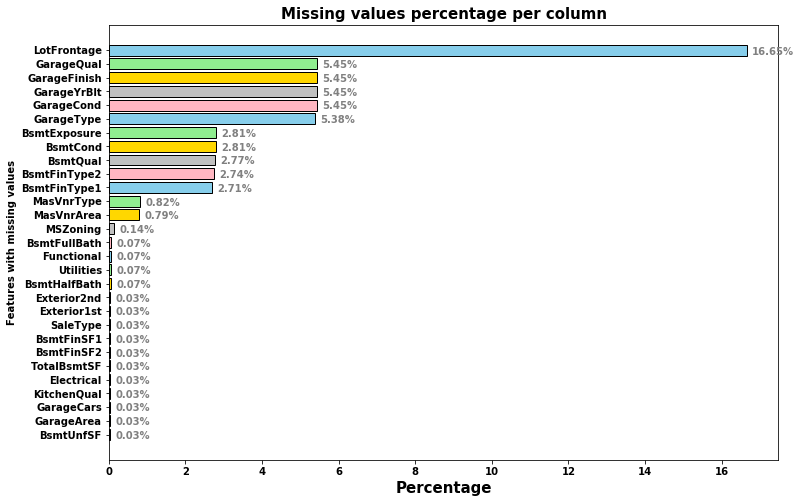

In [18]:
msv2(combined_df1)

Out of the remaining columns, there are a few columns still having some missing values. We fill the numerical ones with the median of the data or 0s depending on the type of data it represents.

In [19]:
#LotFrontage has 16% missing values. Filling with median.
combined_df1['LotFrontage'] = combined_df1.LotFrontage.fillna(combined_df1.LotFrontage.median())
#Masonry Veneer Area having missing values would mean that there is no veneer. Hence we fill with 0.
combined_df1['MasVnrArea'] = combined_df1.MasVnrArea.fillna(0)
#No value for GarageYrBlt would mean no garage exists. But since this is a year value, we cannot fill it with 0s. Hence we fill with median.
combined_df1['GarageYrBlt']=combined_df1["GarageYrBlt"].fillna(1980)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [20]:
combined_df1.shape

(2919, 74)

### Categorical columns with NaNs :

We look at the categorical columns in the data and check which columns have null values.

In [21]:
df_Cat = combined_df1.select_dtypes(include='object')
nan_cols = df_Cat.columns[df_Cat.isnull().any()]
NA_Cat= df_Cat[nan_cols]
NA_Cat.isnull().sum().sort_values(ascending=False)

GarageQual      159
GarageFinish    159
GarageCond      159
GarageType      157
BsmtExposure     82
BsmtCond         82
BsmtQual         81
BsmtFinType2     80
BsmtFinType1     79
MasVnrType       24
MSZoning          4
Functional        2
Utilities         2
Electrical        1
KitchenQual       1
Exterior2nd       1
Exterior1st       1
SaleType          1
dtype: int64

Some of the columns have only a few missing values. We will use the forward fill method to fill these.

In [22]:
cols_to_fill = ['SaleType','Exterior1st','Exterior2nd','KitchenQual',
                'Electrical','Utilities','Functional','MSZoning']

combined_df1[cols_to_fill] = combined_df1[cols_to_fill].fillna(method='ffill')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


The rest of the features contain a large amount of null values. We will fill these with 'None' for the categorical and '0' for the numerical columns, assuming that a missing value indicates that, that particular feature is not present in the house - e.g. No value for 'GarageQual' would mean that the house does not have a garage.

In [23]:
cols = combined_df1.columns
for col in cols:
    if combined_df1[col].dtype == 'object':
        combined_df1[col] = combined_df1[col].fillna('None')
    elif combined_df1[col].dtype != 'object':
        combined_df1[col] = combined_df1[col].fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [24]:
combined_df1.isnull().sum().sort_values(ascending=False).head() #checking whether all the null values have been dealt with

SaleCondition    0
YearRemodAdd     0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
dtype: int64

In [25]:
combined_df1.shape

(2919, 74)

## Feature Engineering

We will add a new feature called **'Total Area'** that sums up the areas of all the floors and the basement. This is because we know that area has a significant impact on the price of a house, and summing it up could help our regression algorithm predict better.

In [26]:
combined_df1['TotalArea'] = combined_df1['TotalBsmtSF'] + combined_df1['1stFlrSF'] + combined_df1['2ndFlrSF'] + combined_df1['GrLivArea'] + combined_df1['GarageArea']
# Creating a new feature 'TotalArea' by adding up the area of all the floors and basement

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
combined_df1['MSSubClass'] = combined_df1['MSSubClass'].apply(str)
combined_df1['YrSold'] = combined_df1['YrSold'].astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Encoding Categorical Data

We use one-hot encoding to encode all the categorical features.

In [29]:
combined_df_onehot = pd.get_dummies(combined_df1)
print(f"the shape of the original dataset {combined_df1.shape}")
print(f"the shape of the encoded dataset {combined_df_onehot.shape}")
print(f"We have {combined_df_onehot.shape[1]- combined_df1.shape[1]} new encoded features")

the shape of the original dataset (2919, 75)
the shape of the encoded dataset (2919, 299)
We have 224 new encoded features


After Data cleaning, feature engineering and encoding, we now split the dataset back into training and test sets.

In [30]:
X_train = combined_df_onehot[:nX]   #nX is the number of rows in the original training set
test = combined_df_onehot[nX:]

print(X_train.shape, test.shape)

(1460, 299) (1459, 299)


## Detecting and eliminating Outliers

Outliers are points in the dataset that seem to buck the trend, usually without a clear reason. An example would be an extremely large house selling for a very low price. We need to remove these from the dataset before training our regression model because they can negatively impact the weights the model will learn.

Text(0.5, 1.0, 'Total Rooms - Price scatter plot')

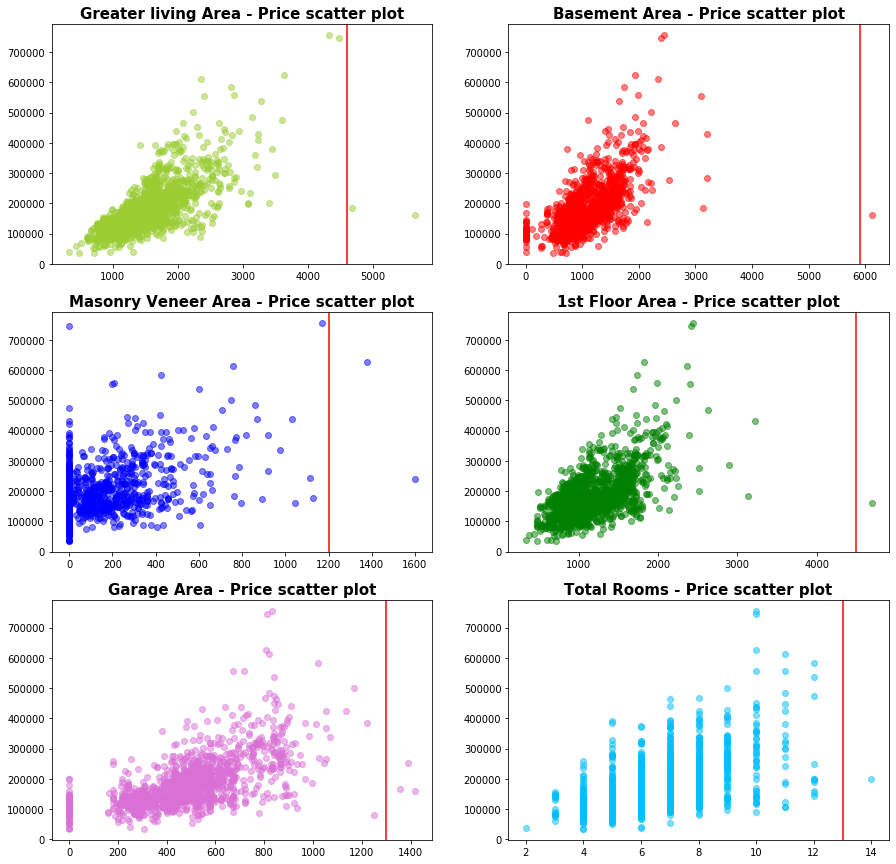

In [31]:
fig = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((3,2),(0,0))
plt.scatter(x=X['GrLivArea'], y=y_train['SalePrice'], color=('yellowgreen'), alpha=0.5)
plt.axvline(x=4600, color='r', linestyle='-')
plt.title('Greater living Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(0,1))
plt.scatter(x=X['TotalBsmtSF'], y=y_train['SalePrice'], color=('red'),alpha=0.5)
plt.axvline(x=5900, color='r', linestyle='-')
plt.title('Basement Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(1,0))
plt.scatter(x=X['MasVnrArea'], y=y_train['SalePrice'], color=('blue'),alpha=0.5)
plt.axvline(x=1200, color='r', linestyle='-')
plt.title('Masonry Veneer Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(1,1))
plt.scatter(x=X['1stFlrSF'], y=y_train['SalePrice'], color=('green'),alpha=0.5)
plt.axvline(x=4500, color='r', linestyle='-')
plt.title('1st Floor Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(2,0))
plt.scatter(x=X['GarageArea'], y=y_train['SalePrice'], color=('orchid'),alpha=0.5)
plt.axvline(x=1300, color='r', linestyle='-')
plt.title('Garage Area - Price scatter plot', fontsize=15, weight='bold' )

ax1 = plt.subplot2grid((3,2),(2,1))
plt.scatter(x=X['TotRmsAbvGrd'], y=y_train['SalePrice'], color=('deepskyblue'),alpha=0.5)
plt.axvline(x=13, color='r', linestyle='-')
plt.title('Total Rooms - Price scatter plot', fontsize=15, weight='bold' )

The outliers are the points in the right that have a larger area or value but a very low sale price. We localize those points by sorting their respective columns in descending order. The head() function uses the number of data points visible beyond the threshold.

In [32]:
print(X['TotRmsAbvGrd'].sort_values(ascending=False).head(1))
print(X['GarageArea'].sort_values(ascending=False).head(3))
print(X['1stFlrSF'].sort_values(ascending=False).head(1))
print(X['MasVnrArea'].sort_values(ascending=False).head(2))
print(X['TotalBsmtSF'].sort_values(ascending=False).head(1))
print(X['GrLivArea'].sort_values(ascending=False).head(2))


Id
636    14
Name: TotRmsAbvGrd, dtype: int64
Id
1299    1418
582     1390
1191    1356
Name: GarageArea, dtype: int64
Id
1299    4692
Name: 1stFlrSF, dtype: int64
Id
298     1600.0
1170    1378.0
Name: MasVnrArea, dtype: float64
Id
1299    6110
Name: TotalBsmtSF, dtype: int64
Id
1299    5642
524     4676
Name: GrLivArea, dtype: int64


Now that we know the index values of the outliers, we can remove them from the training data

In [33]:
x_train = X_train[(X_train['TotRmsAbvGrd'] < 13) & (X_train['MasVnrArea']<1200) & (X_train['1stFlrSF']<4000) & (X_train['TotalBsmtSF']<5000)
                 & (X_train['GarageArea']<1300) & (X_train['GrLivArea']<4600)]

print(f'We removed {X_train.shape[0]- x_train.shape[0]} outliers')

We removed 7 outliers


We do the same thing with "SalePrice" column, we localize those outliers and make sure they are the right outliers to remove.

In [34]:
target = X[['SalePrice']]
target.shape

(1460, 1)

In [35]:
pos = [635,1298,581,1190,297,1169,523]
target.drop(target.index[pos], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
print('We make sure that both train and target sets have the same row number after removing the outliers:')
print( 'Train: ',x_train.shape[0], 'rows')
print('Target:', target.shape[0],'rows')

We make sure that both train and target sets have the same row number after removing the outliers:
Train:  1453 rows
Target: 1453 rows


### Skewness and Kurtosis of the numerical data

**Skewness**: It is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution.
It differentiates extreme values in one versus the other tail. A symmetrical distribution will have a skewness of 0.

There are 2 types of skewness, positive and negative. 

***Positive skewness*** indicates that the data is skewed towards the right side of the graph. The mean and median will be greater than the mode.
***Negative skewness*** indicates that the data is skewed towards the left side of the graph. The mean and median will be less than the mode.

A skewness value close to 0 indicates that the data is fairly symmetrical. So we need to bring the skewness value close to 0.

**Kurtosis**: It is a measure of outliers in the distribution. It defines how heavily the tails of a distribution differ from the tails of a normal distribution.

High kurtosis in a data set is an indicator that data has heavy tails or outliers.
Low kurtosis in a data set is an indicator that data has light tails or lack of outliers.

We need the kurtosis of our data to be less than 3. This indicates that the extreme values are less than that of the normal distribution.


Below is an example of a highly skewed feature - Lot Frontage:

In [37]:
print("Skewness before log transform: ", X['LotFrontage'].skew())
print("Kurtosis before log transform: ", X['LotFrontage'].kurt())

Skewness before log transform:  2.163569142324884
Kurtosis before log transform:  17.452867259818404


We will use log transformation on the skewed variables with the help of the **np.log1p** function.

In [38]:
from scipy.stats import skew

#num_feats = combined_df1.dtypes[combined_df1.dtypes != "object"].index


#skewed_feats = x_train[num_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#skewed_feats = skewed_feats[skewed_feats > 0.55]
#skewed_feats = skewed_feats.index

#x_train[skewed_feats] = np.log1p(x_train[skewed_feats])

In [39]:
print(f"Skewness after log transform: {x_train['LotFrontage'].skew()}")
print(f"Kurtosis after log transform: {x_train['LotFrontage'].kurt()}")

Skewness after log transform: 1.750294700608976
Kurtosis after log transform: 14.837446879539158


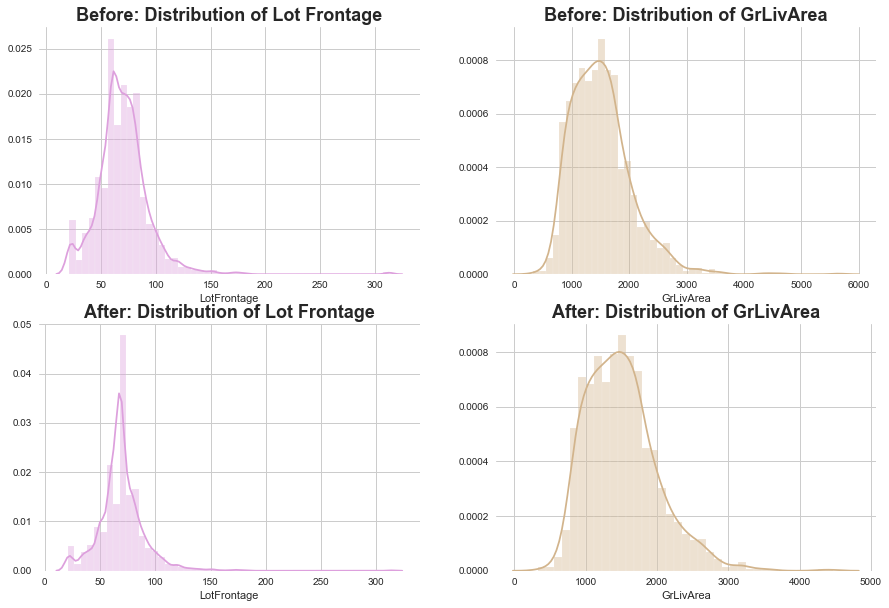

In [40]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,10))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((2,2),(0,0))
sns.distplot(X.LotFrontage, color='plum')
plt.title('Before: Distribution of Lot Frontage',weight='bold', fontsize=18)
#first row sec col
ax1 = plt.subplot2grid((2,2),(0,1))
sns.distplot(X['GrLivArea'], color='tan')
plt.title('Before: Distribution of GrLivArea',weight='bold', fontsize=18)


ax1 = plt.subplot2grid((2,2),(1,0))
sns.distplot(x_train.LotFrontage, color='plum')
plt.title('After: Distribution of Lot Frontage',weight='bold', fontsize=18)
#first row sec col
ax1 = plt.subplot2grid((2,2),(1,1))
sns.distplot(x_train['GrLivArea'], color='tan')
plt.title('After: Distribution of GrLivArea',weight='bold', fontsize=18)
plt.show()

We can see that the distributions for both features were skewed earlier to the right , i.e. positively skewed.
After the application of log transform, the distributions are now less skewed and close to the normal distribution.

Next, we will apply log transform to the target variable as well.

In [41]:
target["SalePrice"] = np.log1p(target["SalePrice"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


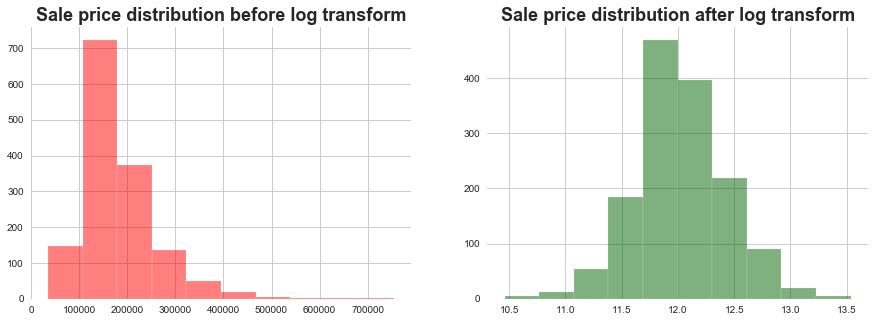

In [42]:
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,5))
#1 rows 2 cols
#first row, first col
ax1 = plt.subplot2grid((1,2),(0,0))
plt.hist(X.SalePrice, bins=10, color='red',alpha=0.5)
plt.title('Sale price distribution before log transform',weight='bold', fontsize=18)
#first row sec col
ax1 = plt.subplot2grid((1,2),(0,1))
plt.hist(target.SalePrice, bins=10, color='darkgreen',alpha=0.5)
plt.title('Sale price distribution after log transform',weight='bold', fontsize=18)
plt.show()

In [43]:
print(f"Skewness after log transform: {target['SalePrice'].skew()}")
print(f"Kurtosis after log transform: {target['SalePrice'].kurt()}")

Skewness after log transform: 0.10839719122800653
Kurtosis after log transform: 0.7775076400529959


## Machine Learning :

We split the data into training and validation sets.

In [44]:
from sklearn.model_selection import train_test_split
#train-test split
target = np.array(target)
X_train_full, X_valid_full, y_train, y_valid = train_test_split(x_train, target, train_size=0.8, test_size=0.2,
                                                                random_state=0)
print(X_train_full.shape,y_train.shape)

(1162, 299) (1162, 1)


We use RobustScaler to scale our data because it's powerful against outliers.

In [45]:
X_train

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,953.0,...,0,0,0,1,0,0,0,0,1,0
1456,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,589.0,...,0,0,0,1,0,0,0,0,1,0
1457,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,877.0,...,0,0,0,1,0,0,0,0,1,0
1458,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [46]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
# transform "x_train"
X_train_full = scaler.fit_transform(X_train_full)
# transform "x_test"
X_valid_full = scaler.transform(X_valid_full)
#Transform the test set
X_test= scaler.transform(test)

In [47]:
X_test

array([[ 0.66666667,  0.57571099, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72222222,  1.25339482,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33333333,  1.14142967, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 5.11111111,  2.72226492, -0.5       , ...,  0.        ,
        -1.        ,  0.        ],
       [-0.33333333,  0.27312324, -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33333333,  0.06456572,  0.5       , ...,  0.        ,
         0.        ,  0.        ]])

In [48]:
from sklearn.metrics import mean_squared_error
def score(prediction): #creating a function to get RMSE for predictions
    return str(math.sqrt(mean_squared_error(y_valid, prediction)))

### Regularization :
Regularizations are techniques used to reduce the error by fitting a function appropriately on the given training set and avoid overfitting. It basically adds a penalty as model complexity increases. The regularization parameter penalizes all the parameters except the intercept so that the model generalizes the data and won’t overfit.

We shall first apply L2 regularizatio. This is done using Ridge regression. L2 regularization forces the weights to be close to zero, but does not make them zero. We need to find the optimum value of alpha(regularization parameter) so as to avoid underfitting. If alpha is too low, the model will generalize too much and end up underfitting the data.

### 1. Ridge Regression:

In [49]:
import sklearn.model_selection as ms
from sklearn.linear_model import Ridge
import math

ridge=Ridge()
parameters= {'alpha':[x for x in range(1,101)]} 

ridge_reg= ms.GridSearchCV(ridge, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)
ridge_reg.fit(X_train_full,y_train)
print(f"The best value of Alpha is: {ridge_reg.best_params_}")
print(f"The best score achieved with Alpha=10 is: {math.sqrt(-ridge_reg.best_score_)}")
ridge_pred=math.sqrt(-ridge_reg.best_score_)


The best value of Alpha is: {'alpha': 25}
The best score achieved with Alpha=10 is: 0.11366883001853073


In [50]:

ridge_mod=Ridge(alpha=15)
ridge_mod.fit(X_train_full,y_train)
y_pred_train=ridge_mod.predict(X_train_full)
y_pred_test=ridge_mod.predict(X_valid_full)

print(f'Root Mean Square Error train =  {str(math.sqrt(mean_squared_error(y_train, y_pred_train)))}')
print(f'Root Mean Square Error test =  {score(y_pred_test)}')   

Root Mean Square Error train =  0.09590924388921633
Root Mean Square Error test =  0.1128750891801704


### Cross-Validation:
We shall use cross validation to check if the error we got earlier holds true throughout the dataset. 
Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter that refers to the number of groups that a given data sample is to be split into.

We will split our data into 5 folds. This runs the model 5 times, each time testing on a different chunk of data.


In [51]:
from sklearn.model_selection import cross_val_score

#Ridge regression
Ridge_CV=Ridge(alpha=15)
MSEs=cross_val_score(Ridge_CV, x_train, target, scoring='neg_mean_squared_error', cv=5)

#RMSE score of the 5 folds
print("RMSE scores of the 5 folds:")
for i,j in enumerate(MSEs):
    j= math.sqrt(np.mean(-j))
    print(f'Fold {i}: {round(j,4)}')

#Final RMSE score with Lasso
print(f'Mean RMSE with Ridge: {round(math.sqrt(np.mean(-MSEs)),4)}')


RMSE scores of the 5 folds:
Fold 0: 0.1104
Fold 1: 0.1183
Fold 2: 0.1207
Fold 3: 0.1042
Fold 4: 0.1123
Mean RMSE with Ridge: 0.1134


The RMSE score after cross-validation was slightly worse than the score earlier. We can see that there is some variation between the 5 folds. This score gives a better idea about the performance of the model on new data.

### 2. Lasso
Next, we shall apply L1 regularization, using Lasso. L1 regularization also penalizes the weights by forcing them to be close to zero, but it also makes some weights for uninformative features to be zero. This acts as feature selection when we have a large number of features, and thus also helps against overfitting.

In [61]:
from sklearn.linear_model import Lasso

params= {'alpha':[0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]}

lasso=Lasso(tol=0.01)
lasso_reg=ms.GridSearchCV(lasso, param_grid=params, scoring='neg_mean_squared_error', cv=15)
lasso_reg.fit(X_train_full,y_train)

print(f'The best value of Alpha is: {lasso_reg.best_params_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8841257712818473, tolerance: 1.7544184626714707
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5625956173880446, tolerance: 1.7251888883994937
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.805051158634806, tolerance: 1.7690883166281473
  positive)


The best value of Alpha is: {'alpha': 0.0009}


In [62]:
lasso_mod=Lasso(alpha=0.0009)
lasso_mod.fit(X_train_full,y_train)
y_lasso_train=lasso_mod.predict(X_train_full)
y_lasso_test_pred=lasso_mod.predict(X_valid_full)

print(f'Root Mean Square Error train  {str(math.sqrt(mean_squared_error(y_train, y_lasso_train)))}')
print(f'Root Mean Square Error test  {score(y_lasso_test_pred)}')

Root Mean Square Error train  0.1019590156062517
Root Mean Square Error test  0.112849882266739


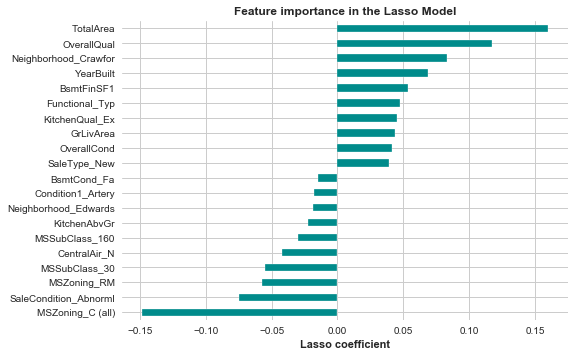

In [63]:
coefs = pd.Series(lasso_mod.coef_, index = x_train.columns)

imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", color='darkcyan')
plt.xlabel("Lasso coefficient", weight='bold')
plt.title("Feature importance in the Lasso Model", weight='bold')
plt.show()

In the above graph, we can see the most important features as observed by the lasso model. Total Area is one of the most significant, as well as a few Neighborhoods, just as we had thought earlier.

In [55]:
print(f"Lasso kept {sum(coefs != 0)} important features and dropped the other  {sum(coefs == 0)} features")

Lasso kept 86 important features and dropped the other  213 features


In [56]:
#Lasso regression
Lasso_CV=Lasso(alpha=0.0009, tol=0.001)
MSEs=ms.cross_val_score(Lasso_CV, x_train, target, scoring='neg_mean_squared_error', cv=5)

#RMSE score of the 5 folds
print("RMSE scores of the 5 folds:")
for i,j in enumerate(MSEs):
    j= math.sqrt(np.mean(-j))
    print(f'Fold {i}: {round(j,4)}')

#Final RMSE score with Lasso
print(f'Mean RMSE with Lasso: {round(math.sqrt(np.mean(-MSEs)),4)}')

RMSE scores of the 5 folds:
Fold 0: 0.1081
Fold 1: 0.117
Fold 2: 0.1205
Fold 3: 0.1037
Fold 4: 0.1109
Mean RMSE with Lasso: 0.1122


As with ridge, we can observe some variation with lasso as well. The mean RMSE value is only slightly lower, not by much.

### 3. ElasticNet:
Next we use ElasticNet, which is a regressor that uses both L1 and L2 regularization. 
We use cross-validation to find :
1. Alpha: Constant that multiplies the penalty terms.
2. L1-ratio: Ratio between the regularizers.

In [57]:
from sklearn.linear_model import ElasticNetCV

alphas = [10,1,0.1,0.01,0.001,0.002,0.003,0.004,0.005,0.00056]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95]

elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alphas,  l1_ratio=l1ratio)

elasticmod = elastic_cv.fit(X_train_full, y_train.ravel())
ela_pred=elasticmod.predict(X_valid_full)
print('Root Mean Square Error test = ' + str(math.sqrt(mean_squared_error(y_valid, ela_pred))))
print(elastic_cv.alpha_)
print(elastic_cv.l1_ratio_)

Root Mean Square Error test = 0.11060454319167105
0.00056
0.95


### 4. XGBoost regressor:

Next we shall try the XGBoost regressor and see if there is any improvement in the score.

Average RMSE score for n_estimators : 100 is : 1.5518
Average RMSE score for n_estimators : 200 is : 0.2509
Average RMSE score for n_estimators : 300 is : 0.1283
Average RMSE score for n_estimators : 400 is : 0.122
Average RMSE score for n_estimators : 500 is : 0.121
Average RMSE score for n_estimators : 600 is : 0.1207
Average RMSE score for n_estimators : 700 is : 0.1207


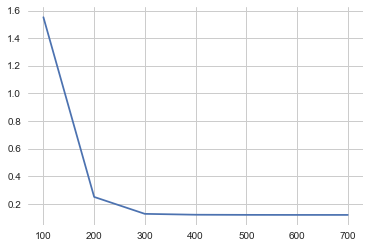

In [64]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
%matplotlib inline

def get_score(n_estimators):
    
    
    xgb = XGBRegressor(n_estimators=n_estimators, learning_rate = 0.02)
    
    scores_new = -1 * cross_val_score(xgb, X_train_full, y_train,
                              cv=5,
                              scoring='neg_mean_squared_error')

    print("Average RMSE score for n_estimators : {} is :".format(n_estimators), round(math.sqrt(np.mean(scores_new)),4))
    return math.sqrt(np.mean(scores_new))

results = {} #dict to store results
for i in range(100,800,100):  #checking different values of n_estimators
        results[i] = get_score(i)

plt.plot(list(results.keys()), list(results.values()))
plt.show()

We run GridSearchCV to get the best hyperparameters, which we will then apply and fit the model to the training set.

In [65]:
from sklearn.model_selection import GridSearchCV

#xg_reg = XGBRegressor()
#xgparam_grid= {'learning_rate' : [0.01],'n_estimators':[2000,3000,4000],
#                                     'reg_alpha':[0.0001,0.01],
#                                    'reg_lambda':[1,0.01]}
#
#xg_grid=GridSearchCV(xg_reg, param_grid=xgparam_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#xg_grid.fit(X_train_full,y_train)
#print(xg_grid.best_estimator_)
#print(xg_grid.best_score_)

In [66]:
from xgboost import XGBRegressor

xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
            objective='reg:squarederror',
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=4000, n_jobs=1, random_state=0,
             reg_alpha=0.0001, reg_lambda=0.01, scale_pos_weight=1, subsample=1,
              validate_parameters=1, verbosity=1)
xgmod=xgb.fit(X_train_full,y_train)
xg_pred=xgmod.predict(X_valid_full)
print(f'Root Mean Square Error test = {score(xg_pred)}')

Root Mean Square Error test = 0.11782507564547799


### **Ensemble methods:**
The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Having run 4 different regression methods so far, we shall now combine them using ensemble methods.

### Voting Regressor:
A voting regressor is an ensemble meta-estimator that fits base regressors each on the whole dataset. It, then, averages the individual predictions to form a final prediction.

In [67]:
from sklearn.ensemble import VotingRegressor

vote_mod = VotingRegressor([('Ridge', ridge_mod), ('Lasso', lasso_mod), ('Elastic', elastic_cv), 
                            ('XGBRegressor', xgb)])
vote= vote_mod.fit(X_train_full, y_train.ravel())
vote_pred=vote.predict(X_valid_full)

print(f'Root Mean Square Error test = {score(vote_pred)}')

Root Mean Square Error test = 0.1096881106357464


### Stacking Regressor:
Stacked generalization consists of stacking the output of individual estimator and using a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

We stack all the previous models, including the Voting Regressor with XGBoost as the meta regressor/ final regressor.

In [69]:
!pip install mlxtend


In [70]:
from mlxtend.regressor import StackingRegressor


stackreg = StackingRegressor(regressors=[elastic_cv,ridge_mod, lasso_mod, vote_mod], 
                           meta_regressor=xgb, use_features_in_secondary=True
                          )

stack_mod=stackreg.fit(X_train_full, y_train.ravel())
stacking_pred=stack_mod.predict(X_valid_full)

print(f'Root Mean Square Error test = {score(stacking_pred)}')

Root Mean Square Error test = 0.11141342559734485


Finally, we average out the results(predictions) of 3 models with the best RMSE values. The coefficients assigned were tested manually, and the selected combination yielded the best results.

In [71]:
final_test=(0.4*vote_pred+0.4*stacking_pred+ 0.2*y_lasso_test_pred)
print(f'Root Mean Square Error test=  {score(final_test)}')

Root Mean Square Error test=  0.10874613417037804


### Fit the models on test data:
We fit the models on the test data, and apply np.expm1 to convert the numbers back, since we log transformed the data earlier.

In [72]:
#VotingRegressor to predict the final Test
vote_test = vote_mod.predict(X_test)
final1=np.expm1(vote_test)

#StackingRegressor to predict the final Test
stack_test = stackreg.predict(X_test)
final2=np.expm1(stack_test)

#LassoRegressor to predict the final Test
lasso_test = lasso_mod.predict(X_test)
final3=np.expm1(lasso_test)


In [73]:
# averaging the predictions before submitting
final=(0.4*final1+0.4*final2+0.2*final3)

In [74]:
final

array([122453.84649806, 157868.98437295, 181578.77731407, ...,
       165223.68757183, 114274.59103217, 228875.49121835])

In [75]:
# creating submission file for submitting to the competition
output = pd.DataFrame({'Id': X_test_full.index,
                       'SalePrice': final})
output.to_csv('submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,122453.846498
1,1462,157868.984373
2,1463,181578.777314
3,1464,197469.518059
4,1465,186330.693460
